## Car with Obstacles

In [7]:
using TrajectoryOptimization
using Plots, LinearAlgebra

Import the car model

In [8]:
model = Dynamics.car_model
n = model.n # number of states
m = model.m; # number of controls

Define numerical type

In [9]:
T = Float64;

Define initial and goals states

In [10]:
x0 = [0.; 0.; 0.]
xf = [1.; 1.; 0.]

3-element Array{Float64,1}:
 1.0
 1.0
 0.0

Define a cost function, e.g., quadratic

In [11]:
Q = (1.0e-2)*Diagonal(I,n)
R = (1.0e-1)*Diagonal(I,m)
Qf = 1000.0*Diagonal(I,n)
cost = LQRCost(Q, R, Qf, xf);

Define obstacles

In [51]:
# create obstacle constraints
r_circle = 0.1
circles = ((0.4,0.25,r_circle),(0.8,0.65,r_circle),(1.0,0.85,r_circle))
n_circles = length(circles)

function circle_obs(c,x,u)
    for i = 1:n_circles
        c[i] = TrajectoryOptimization.circle_constraint(x,circles[i][1],circles[i][2],circles[i][3])
    end
    return nothing
end

obs = Constraint{Inequality}(circle_obs,n,m,n_circles,:obs);

Define a problem

In [52]:
N = 101 # number of knot points
dt = 0.1 # total time

U = [rand(m) for k = 1:N-1] 

obj = TrajectoryOptimization.Objective(cost,N) # objective with same stagewise costs
constraints = TrajectoryOptimization.ProblemConstraints([obs],N) # constraints at each stage
    
prob = Problem(model,obj, constraints=constraints, x0=x0, integration=:rk4, N=N, dt=dt)
initial_controls!(prob,U); # initialize problem with controls

prob_uncon = Problem(model,obj, constraints=constraints, x0=x0, integration=:rk4, N=N, dt=dt)
initial_controls!(prob_uncon,U); # initialize problem with controls

Solve problem

In [53]:
solve!(prob, TrajectoryOptimization.ALTROSolverOptions{T}(verbose=true)) # solve with iLQR

Solve unconstrained problem

In [54]:
solve!(prob_uncon, iLQRSolverOptions{T}(verbose=true)) # solve with iLQR

    iter cost          expected    z         α         ρ         dJ        grad      zero_count info                                              
____----------------------------------------------------------------------------------------------------------------------------------------------
    1     10965.798001  5554.74095  0.311593  0.25      0e+00     1730.817  4.891908 0          
    2     2150.9193803  8224.27096  1.071813  0.5       0e+00     8814.879  1.918613 0          
    3     714.64503626  2150.88695  0.667759  1         0e+00     1436.274  0.852802 0          
    4     21.94168421   714.632072  0.969315  1         0e+00     692.7034  0.738211 0          
    5     11.135675404  16.4459667  0.657061  0.5       0e+00     10.80601  0.316045 0          
    6     0.0856319513  11.1200379  0.993706  1         0e+00     11.05004  0.34569  0          
    7     0.0160875621  0.07129066  0.975505  1         0e+00     0.069544  0.100062 0          
    8     0.0141353471  0.0

0.0082612189952771

In [65]:
x = [prob.X[k][1] for k = 1:N]
y = [prob.X[k][2] for k = 1:N]

x_uncon = [prob_uncon.X[k][1] for k = 1:N]
y_uncon = [prob_uncon.X[k][2] for k = 1:N];

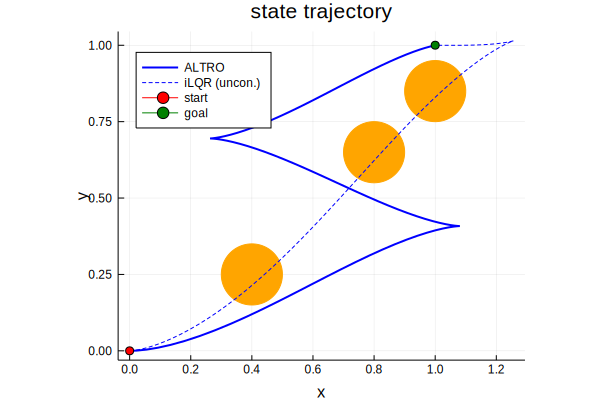

In [66]:
plot()
plot_obstacles(circles,:orange)
plot!(x,y,xlabel="x",ylabel="y",label="ALTRO",legend=:topleft,color=:blue,width=2,ratio=:equal,title="state trajectory")
plot!(x_uncon,y_uncon,xlabel="x",ylabel="y",label="iLQR (uncon.)",legend=:topleft,color=:blue,linestyle=:dash,width=1,ratio=:equal,title="state trajectory")

plot!((x[1],y[1]),marker=:circle,color=:red,label="start")
plot!((x[end],y[end]),marker=:circle,color=:green,label="goal")

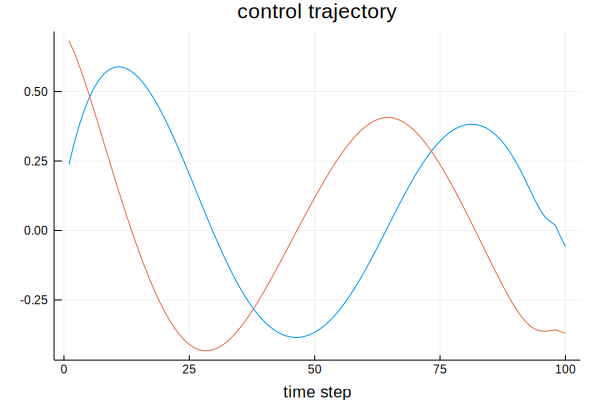

In [63]:
plot(prob.U,xlabel="time step",legend=:none,title="control trajectory")